In [3]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Our custom libraries!
import sys
sys.path.append("..")
# !pip install ds_utils
# from ds_utils.sample_data import *

import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 12

In [4]:
# Load the data
data = pd.read_csv("./mailing1.csv")
# Let's take a look at the data
data.head()

,Income,Firstdate,Lastdate,Amount,rfaf2,rfaa2,pepstrfl,glast,gavr,class
0,3,9409,9509,0.06,1,G,0,50,30.00,0
1,2,9201,9602,0.16,4,G,X,20,20.55,1
2,0,9510,9603,0.20,4,E,0,5,8.75,0
3,6,9409,9603,0.13,2,G,0,25,22.50,0
4,0,9310,9511,0.10,1,G,0,25,12.50,0


In [5]:
for field in ['rfaa2', 'pepstrfl']:
    dummies = pd.get_dummies(data[field])
    dummies.columns = [field + "_" + s for s in dummies.columns]
    data = pd.concat([data, dummies], axis=1).drop(field, axis="columns")
    
data.head()

,Income,Firstdate,Lastdate,Amount,rfaf2,glast,gavr,class,rfaa2_D,rfaa2_E,rfaa2_F,rfaa2_G,pepstrfl_0,pepstrfl_X
0,3,9409,9509,0.06,1,50,30.00,0,0,0,0,1,1,0
1,2,9201,9602,0.16,4,20,20.55,1,0,0,0,1,0,1
2,0,9510,9603,0.20,4,5,8.75,0,0,1,0,0,1,0
3,6,9409,9603,0.13,2,25,22.50,0,0,0,0,1,1,0
4,0,9310,9511,0.10,1,25,12.50,0,0,0,0,1,1,0


In [6]:
# Split our data
X = data.drop(['class'], axis=1)
Y = data['class']
X_mailing_train, X_mailing_test, Y_mailing_train, Y_mailing_test = train_test_split(X, Y, test_size=.25, random_state=42)

# Make and fit a model on the training data
model_mailing = LogisticRegression(C=1000000, solver='liblinear')
model_mailing.fit(X_mailing_train, Y_mailing_train)

# Get probabilities of being a (We saw this last class !!)
probabilities = model_mailing.predict_proba(X_mailing_test)[:, 1]

In [7]:
prediction = probabilities > 0.5

# Build and print a confusion matrix
confusion_matrix_large = pd.DataFrame(metrics.confusion_matrix(Y_mailing_test, prediction, labels=[1, 0]).T,
                                columns=['p', 'n'], index=['Y', 'N'])
print (confusion_matrix_large)

    p     n
Y   0     0
N  82  1543


In [8]:
# Let's move the threshold down
prediction = probabilities > 0.05

# Build and print a confusion matrix
confusion_matrix_small = pd.DataFrame(metrics.confusion_matrix(Y_mailing_test, prediction, labels=[1, 0]).T,
                                columns=['p', 'n'], index=['Y', 'N'])
print (confusion_matrix_small)

    p     n
Y  35   497
N  47  1046


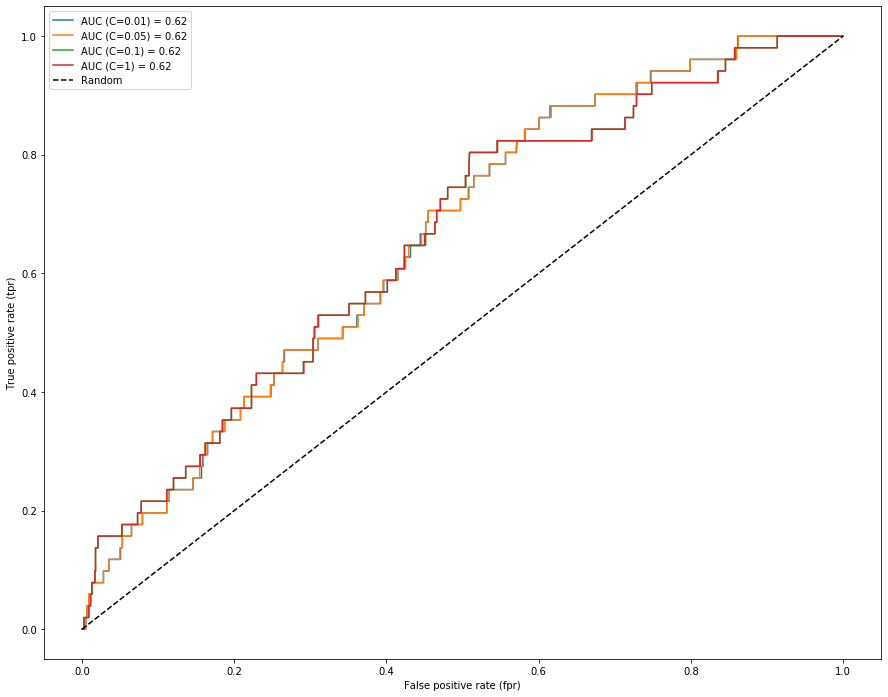

In [9]:
#Split train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

# Fit a logistic regression model
for c in [0.01, 0.05, .1, 1]:
    model = LogisticRegression(C=c, solver='liblinear')
    model.fit(X_train, Y_train)

    # Get the probability of Y_test records being = 1
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability_1)
    
    # Get the area under the curve (AUC)
    auc = np.mean(cross_val_score(model, X, Y, scoring="roc_auc", cv=5))

    # Plot the ROC curve
    plt.plot(fpr, tpr, label="AUC (C=" + str(c) + ") = " + str(round(auc, 2)))
    
plt.xlabel("False positive rate (fpr)")
plt.ylabel("True positive rate (tpr)")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.legend(loc='best')

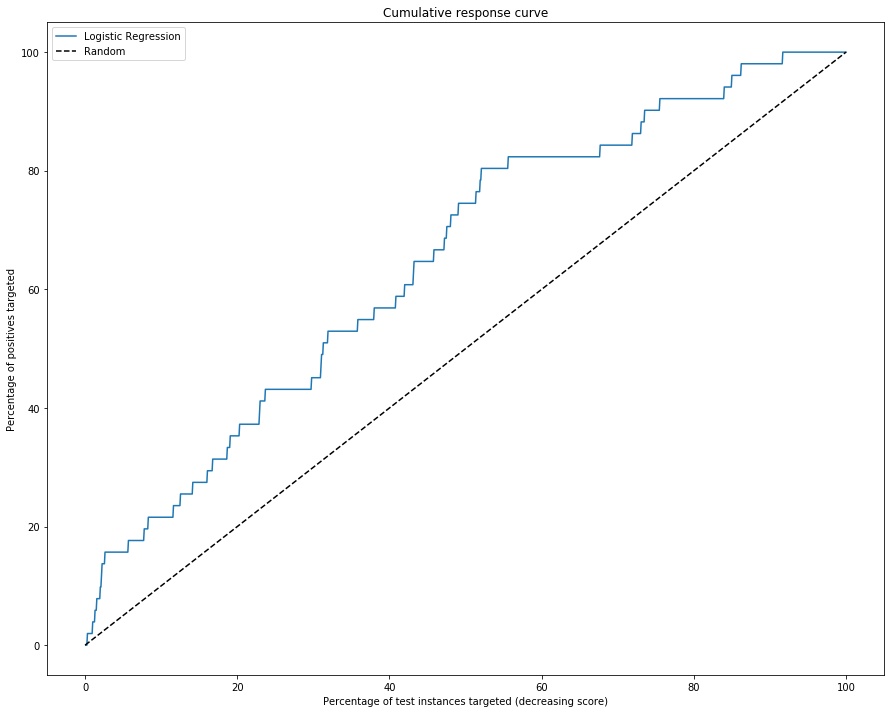

In [10]:
def build_cumulative_curve(model, scale=100):
    # Fit model
    model.fit(X_train, Y_train)

    # Get the probability of Y_test records being = 1
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Sort theseprobabilities and the true value in descending order of probability
    order = np.argsort(Y_test_probability_1)[::-1]
    Y_test_probability_1_sorted = Y_test_probability_1[order]
    Y_test_sorted = np.array(Y_test)[order]

    # Build the cumulative response curve
    x_cumulative = np.arange(len(Y_test_probability_1_sorted)) + 1
    y_cumulative = np.cumsum(Y_test_sorted)

    # Rescale
    x_cumulative = np.array(x_cumulative)/float(x_cumulative.max()) * scale
    y_cumulative = np.array(y_cumulative)/float(y_cumulative.max()) * scale
    
    return x_cumulative, y_cumulative

def plot_cumulative_curve(models):
    # Plot curve for each model
    for key in models:
        x_cumulative, y_cumulative = build_cumulative_curve(models[key])
        plt.plot(x_cumulative, y_cumulative, label=key)
    # Plot other details
    plt.plot([0,100], [0,100], 'k--', label="Random")
    plt.xlabel("Percentage of test instances targeted (decreasing score)")
    plt.ylabel("Percentage of positives targeted")
    plt.title("Cumulative response curve")
    plt.legend()

models = {"Logistic Regression": LogisticRegression(C=1.0, solver="liblinear")}
plot_cumulative_curve(models)

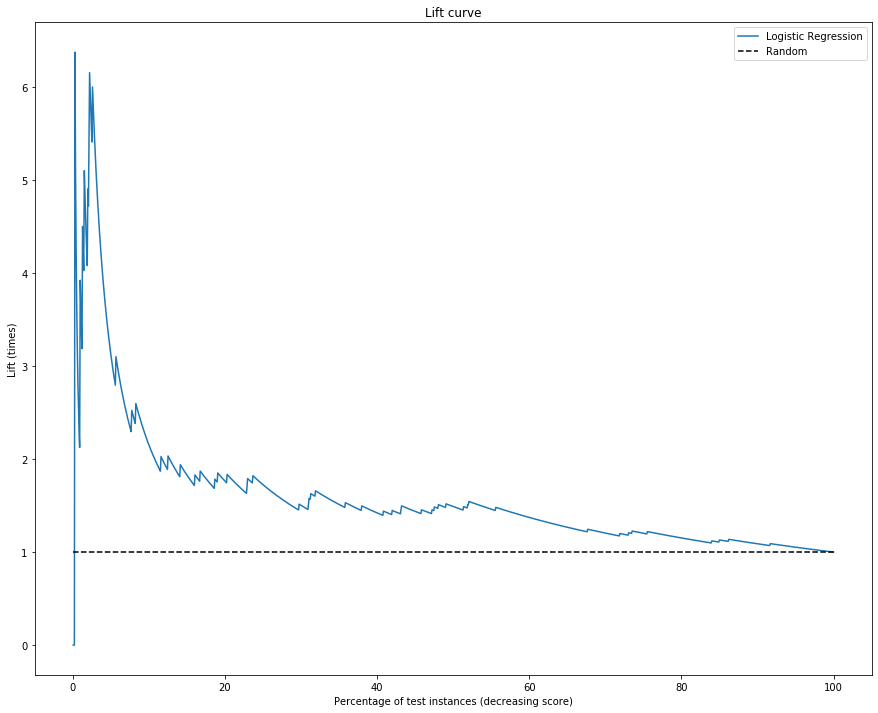

In [11]:
def plot_lift_curve(models):
    # Plot curve for each model
    for key in models:
        x_cumulative, y_cumulative = build_cumulative_curve(models[key])
        plt.plot(x_cumulative, y_cumulative/x_cumulative, label=key)
    # Plot other details
    plt.plot([0,100], [1,1], 'k--', label="Random")
    plt.xlabel("Percentage of test instances (decreasing score)")
    plt.ylabel("Lift (times)")
    plt.title("Lift curve")
    plt.legend()

plot_lift_curve(models)

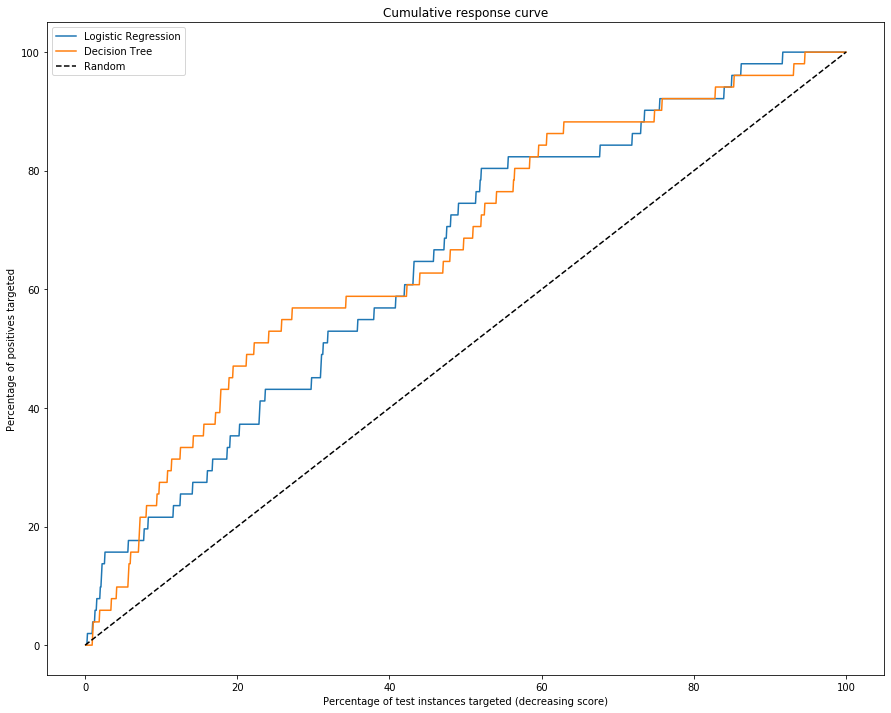

In [12]:
models = {"Logistic Regression": LogisticRegression(C=1.0, solver="liblinear"), 
          "Decision Tree": DecisionTreeClassifier(criterion="entropy", min_samples_leaf=300, random_state=42)}
plot_cumulative_curve(models)

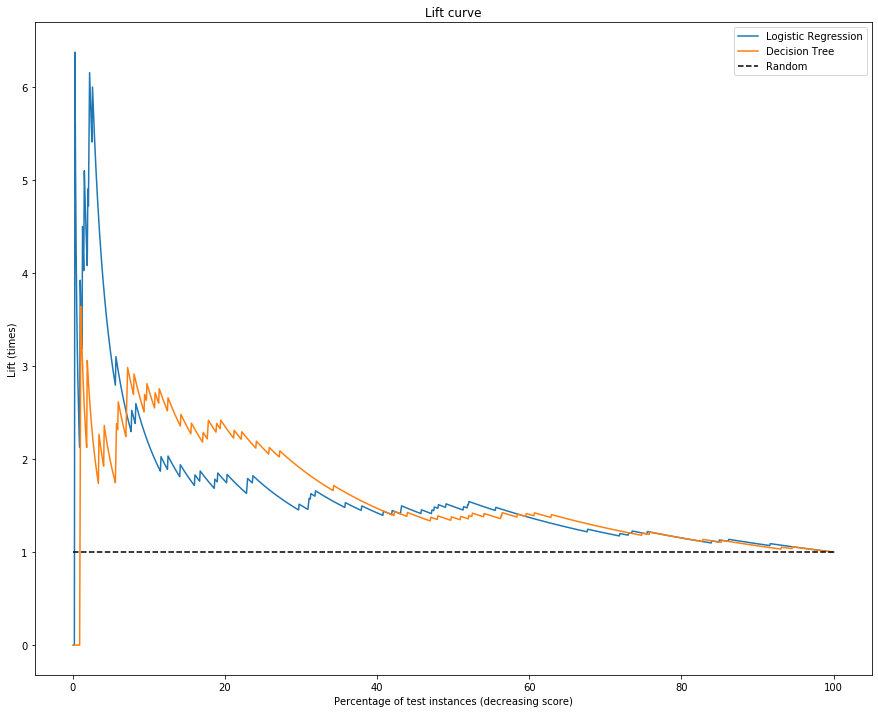

In [13]:
plot_lift_curve(models)

In [14]:
# Let's say that each offer costs 1 to make and market,and each accepted offerearns
# 18, for a profit of $17. The cost matrix would be:
unit_cost = 1
unit_revenue = 18
cost_matrix = pd.DataFrame([[unit_revenue - unit_cost, - unit_cost], [0, 0]], columns=['p', 'n'], index=['Y', 'N'])
print ("Cost matrix")
print (cost_matrix)


Cost matrix
    p  n
Y  17 -1
N   0  0


In [15]:
print ("Confusion matrix with threshold = 50% to predict labels")
print (confusion_matrix_large)
print ("\n")
print ("Confusion matrix with threshold = 5% to predict labels")
print (confusion_matrix_small)

Confusion matrix with threshold = 50% to predict labels
    p     n
Y   0     0
N  82  1543


Confusion matrix with threshold = 5% to predict labels
    p     n
Y  35   497
N  47  1046


In [16]:
profit_in_large = np.sum((confusion_matrix_large * cost_matrix).values)
profit_in_small = np.sum((confusion_matrix_small * cost_matrix).values)

print ("Expected profit per targeted individual with a cutoff of 50%% is $%.2f." % profit_in_large)
print ("Expected profit per targeted individual with a cutoff of 5%% is $%.2f." % profit_in_small)

Expected profit per targeted individual with a cutoff of 50% is $0.00.
Expected profit per targeted individual with a cutoff of 5% is $98.00.


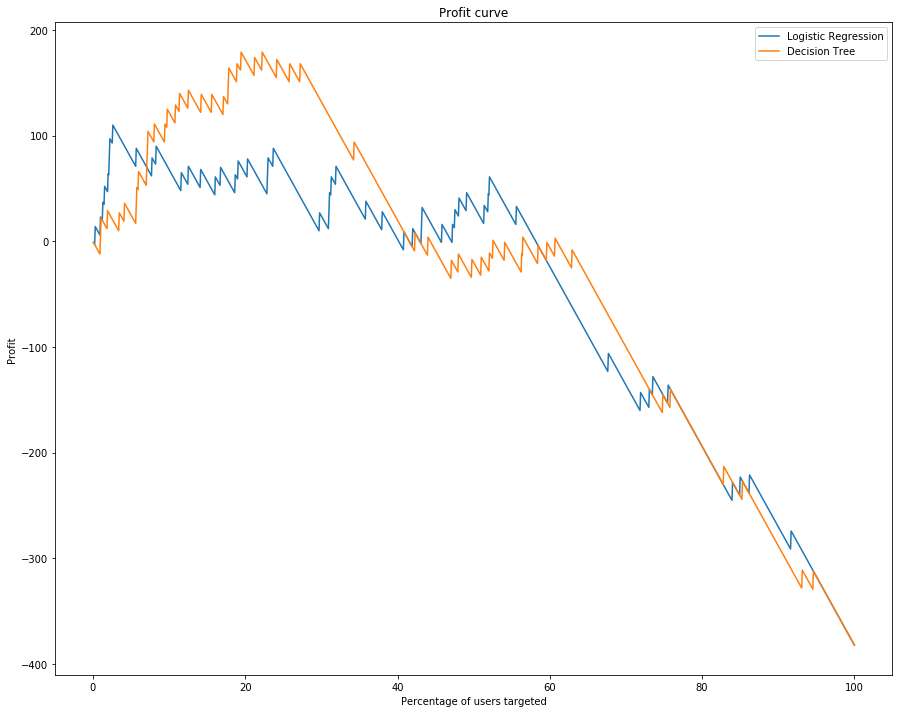

In [17]:
unit_cost = -cost_matrix['n']['Y']
unit_revenue = cost_matrix['p']['Y'] + unit_cost

def plot_profit_curve(models):
    # Plot curve for each model
    total_obs = len(Y_test)
    total_pos = Y_test.sum()
    for key in models:
        x_cumulative, y_cumulative = build_cumulative_curve(models[key], scale=1)
        profits = unit_revenue * y_cumulative * total_pos - unit_cost * x_cumulative * total_obs
        plt.plot(x_cumulative*100, profits, label=key)
    # Plot other details
    plt.xlabel("Percentage of users targeted")
    plt.ylabel("Profit")
    plt.title("Profit curve")
    plt.legend()
    
plot_profit_curve(models)